# Analiza sieci tramwajowej w Poznaniu

Przedmiotem analizy jest sieć tramwajowa w Poznaniu. Dane o przejazdach pozyskaliśmy samodzielnie ze strony ZTM: https://www.ztm.poznan.pl/pl/rozklad-jazdy/ przy użyciu skryptu skrapującego. Dane o lokalizacji przystanków pozyskaliśmy ręcznie z Google Maps, ponieważ nigdzie niestety takie dane nie były dostępne.

### Pytania o charakterze biznesowym:
* Które węzły są w sieci najważniejsze z punktu widzenia ewentualnego wyłączenia z użycia?
* Jakie nowe połączenie można dodać, aby zmniejszyć ryzyko zablokowania całej komunikacji przez pojedynczą awarię?

### Importy

In [112]:
from collections import namedtuple
from copy import deepcopy
from heapq import nlargest
from itertools import combinations
from math import radians
from operator import itemgetter, attrgetter
from random import seed, shuffle
from typing import Mapping, List, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
from networkx.algorithms.community import greedy_modularity_communities
from sklearn.metrics.pairwise import haversine_distances
from tqdm import tqdm

seed(0)
plt.style.use('ggplot')

### Wczytanie danych

In [113]:
def read_routes() -> Mapping[str, List]:
    routes = {}

    trams = list(range(1, 19)) + [201]
    for tram in trams:
        stops = None
        with open(f'./data/{tram}there') as f:
            stops = f.read().splitlines()
            stops = [s.strip() for s in stops]
        routes[f"{tram}there"] = stops

        with open(f'./data/{tram}back') as f:
            stops = f.read().splitlines()
            stops = [s.strip() for s in stops]
        routes[f"{tram}back"] = stops
    return routes


def read_coords() -> Mapping[str, Tuple]:
    result = {}
    with open(f'./data/coords') as f:
        lines = f.read().splitlines()
        for line in lines:
            line = line.strip()
            stop_name, x, y = line.split(",")
            result[stop_name] = (float(x.strip()), float(y.strip()))
    return result

In [114]:
route_to_stops: Mapping[str, List] = read_routes()
stop_to_location: Mapping[str, Tuple] = read_coords()

In [115]:
# just to check if we have all coords
for r, stops in route_to_stops.items():
    for stop in stops:
        if stop not in stop_to_location:
            print(stop)

### Przykładowa trasa: 16there

In [116]:
route_to_stops['16there']

['Franowo (FRWO42)',
 'Szwajcarska (SZWA42)',
 'Szwedzka (SZWE42)',
 'Piaśnicka/Kurlandzka (PK42)',
 'Piaśnicka Rynek (PIAR42)',
 'Os. Lecha (OSLE42)',
 'Os. Tysiąclecia (OSTY42)',
 'Polanka (POKA42)',
 'Kórnicka (KORN44)',
 'Kórnicka (KORN45)',
 'Baraniaka (BAKA42)',
 'Rondo Śródka (ROSR44)',
 'Rondo Śródka (ROSR42)',
 'Katedra (KATE42)',
 'Małe Garbary (MAGA42)',
 'Pl. Wielkopolski (PLWI42)',
 'Pl. Ratajskiego (PLRA42)',
 'Fredry (FRRY42)',
 'Most Teatralny (MT44)',
 'Słowiańska (SLKA41)',
 'Aleje Solidarności (ALSO41)',
 'Lechicka Poznań Plaza (LECH41)',
 'Kurpińskiego (KURP41)',
 'Szymanowskiego (SZYM41)',
 'Os. Sobieskiego (SOB41)']

### Przykładowa lokalizacja

In [117]:
stop_to_location['Franowo (FRWO42)']

(52.38168410642868, 17.00151548366702)

### Utworzenie skierowanego Multigrafu

In [118]:
G = nx.MultiDiGraph()

# Adding nodes (stops)
for stop_name, coords in stop_to_location.items():
    G.add_node(stop_name, location=(coords[1], coords[0]))

# Adding directed edges (between each pair of stops on a route)
for tram in list(range(1, 19)) + [201]:
    edge_color = np.random.rand(3, )  # assign some random color to a tram route (there and back)

    route = f"{tram}there"
    stops_there = route_to_stops[route]
    edges = [(stops_there[i], stops_there[i + 1]) for i in range(len(stops_there) - 1)]
    G.add_edges_from(edges, route=route, color=edge_color)

    route = f"{tram}back"
    stops_back = route_to_stops[route]
    edges = [(stops_back[i], stops_back[i + 1]) for i in range(len(stops_back) - 1)]
    G.add_edges_from(edges, route=route, color=edge_color)

#     G.add_edge(stops_there[-1], stops_back[0]) # closing the cycle
#     G.add_edge(stops_back[-1], stops_there[0]) # closing the cycle

### Narysowany graf (bez etykiet)
Etykiety niestety przyciemniały ogólny obraz grafu. Wydaje się, że jest on wiernym odwzorowaniem sieci tramwajowej w Poznaniu. Trasy zostały pokolorowane w zależności od numeru tramwaju.

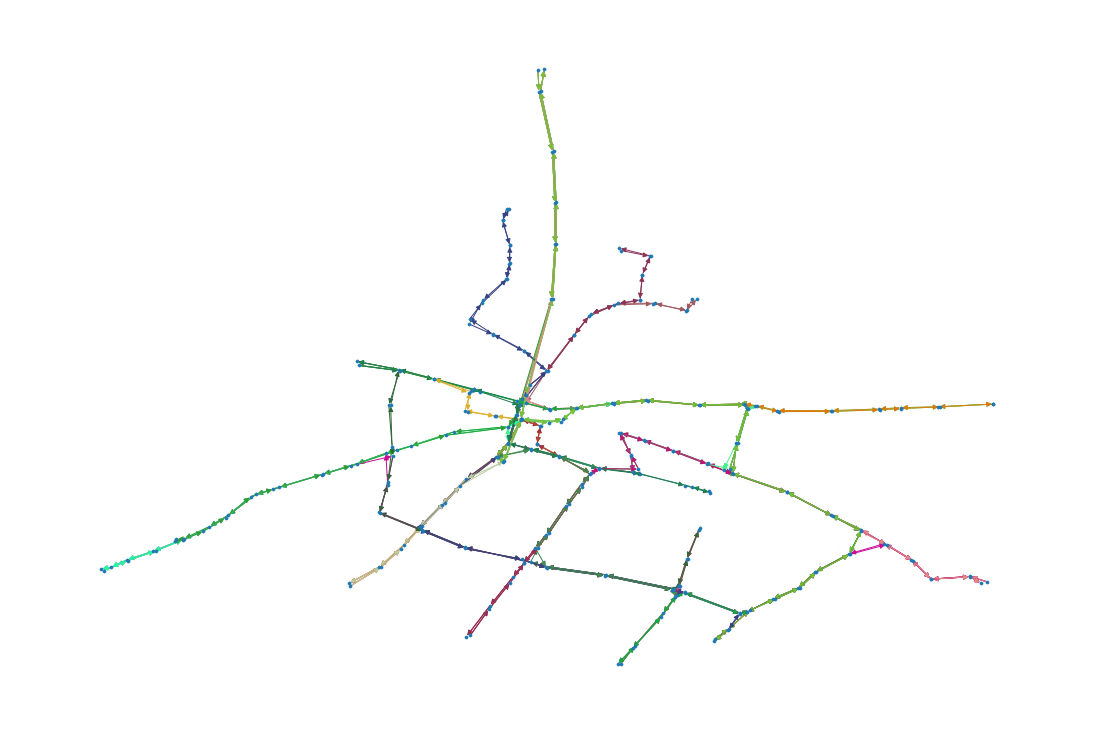

In [119]:
plt.figure(figsize=(15, 10))
colors = nx.get_edge_attributes(G, 'color').values()
nx.draw(G, nx.get_node_attributes(G, 'location'), with_labels=False, node_size=10, edge_color=colors)

### Rozkład stopni wyjściowych i wejściowych

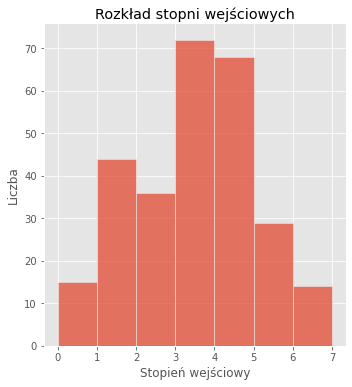

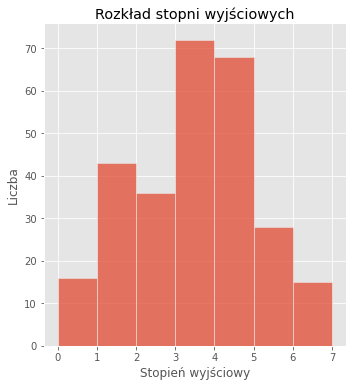

In [120]:
# Rozkład stopni wejściowych
degree_sequence = [d for n, d in G.in_degree()]

sns.displot(degree_sequence, binwidth=1)
plt.title("Rozkład stopni wejściowych")
plt.ylabel("Liczba")
plt.xlabel("Stopień wejściowy")
plt.show()

# Rozkład stopni wyjściowych
degree_sequence = [d for n, d in G.out_degree()]
sns.displot(degree_sequence, binwidth=1)
plt.title("Rozkład stopni wyjściowych")
plt.ylabel("Liczba")
plt.xlabel("Stopień wyjściowy")
plt.show()

Wykresy wyglądają tak samo, ponieważ w większości przypadków do każdego z wierzchołków w naszym grafie wchodzi tyle samo krawędzi ile wychodzi. (Zazwyczaj tramwaje kursują w obie strony po tych samych trasach)

Sprawdźmy, który z wierzchołków ma największy stopień wejściowy/wyjściowy:

In [121]:
max(G.in_degree(), key=itemgetter(1))

('Most Dworcowy (MODW71)', 7)

In [122]:
max(G.out_degree(), key=itemgetter(1))

('Most Dworcowy (MODW71)', 7)

Największy stopień wejściowy i wyjściowy ma **Most Dworcowy**. Z tego powodu węzeł ten może być ważny i w przypadku remontu bądź awarii wiele tras będzie musiało ulec zmianie.

### Rozkład długości najkrótszych ścieżek

In [123]:
Path = namedtuple('Path', 'len, src, trg')
shortest_paths = []

for source, target in tqdm(combinations(stop_to_location.keys(), 2)):
    try:
        path = nx.shortest_path(G, source=source, target=target)
        shortest_paths.append(Path(len(path), source, target))
    except:
        pass

38503it [00:00, 39576.72it/s]


Text(0.5, 6.79999999999999, 'Długość najkrótszej ścieżki')

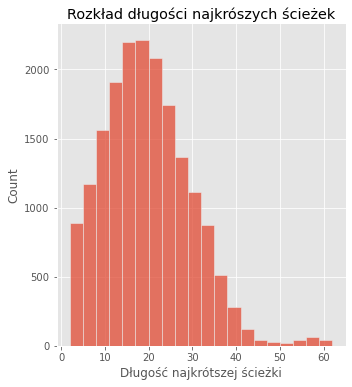

In [124]:
sns.displot(list(map(attrgetter('len'), shortest_paths)), binwidth=3)
plt.title("Rozkład długości najkrószych ścieżek")
plt.xlabel("Liczba ścieżek")
plt.xlabel("Długość najkrótszej ścieżki")

Rozkład jest prawostronnie skośny, tzn istnieją pewne pary wierzchołków, dla których najkrótsza ścieżka prowadzi przez aż 60 wierzchołków w grafie!

### Jakie to pary?

In [125]:
Path.__repr__ = lambda self: f'Len: {self.len:<3} {self.src:<27}{self.trg}'
nlargest(10, shortest_paths, attrgetter('len'))

[Len: 62  Dworzec Zachodni (DWZA71)  Dworzec Zachodni (DWZA72),
 Len: 62  Dworzec Zachodni (DWZA71)  Bukowska (BUKO41),
 Len: 62  Bukowska (BUKO42)          Bukowska (BUKO41),
 Len: 61  Dworzec Zachodni (DWZA71)  Park Wilsona (PAWI72),
 Len: 61  Dworzec Zachodni (DWZA71)  Rondo Nowaka-Jeziorańskiego (RONJ73),
 Len: 61  Dworzec Zachodni (DWZA71)  Półwiejska (POLW92),
 Len: 61  Park Wilsona (PAWI71)      Dworzec Zachodni (DWZA72),
 Len: 61  Park Wilsona (PAWI71)      Bukowska (BUKO41),
 Len: 61  Bukowska (BUKO42)          Rondo Nowaka-Jeziorańskiego (RONJ73),
 Len: 61  Bukowska (BUKO42)          Półwiejska (POLW92)]

Są to wierzchołki po przeciwległych stronach drogi... Ma to trochę sensu, ponieważ aby do nich dotrzeć (tramwajem!) zazwyczaj trzeba gdzieś zrobić jakąś pętlę, a więc pokonać bardzo wiele wierzchołków. Jednak nie do końca takiej odpowiedzi się spodziewaliśmy. Aby dotrzeć do interesującej nas odpowiedzi, musielibyśmy połączyc wierzchołki po przeciwległej stronie ulicy.

In [126]:
code2name = lambda x: x.split(' (')[0]

D = nx.Graph()

# Adding nodes (stops)
for stop_code, coords in stop_to_location.items():
    stop_name = code2name(stop_code)
    if stop_name not in D:
        D.add_node(stop_name, location=(coords[1], coords[0]))

colors = sns.color_palette('Set3', n_colors=20)
# Adding directed edges (between each pair of stops on a route)
for i, tram in enumerate(list(range(1, 19)) + [201]):
    edge_color = colors[i]  # assign some random color to a tram route (there and back)

    route = f"{tram}there"
    stops_there = route_to_stops[route]
    edges = [(code2name(stops_there[i]), code2name(stops_there[i + 1])) for i in range(len(stops_there) - 1)]
    D.add_edges_from(edges, route=route, color=edge_color)

    route = f"{tram}back"
    stops_back = route_to_stops[route]
    edges = [(code2name(stops_back[i]), code2name(stops_back[i + 1])) for i in range(len(stops_back) - 1)]
    D.add_edges_from(edges, route=route, color=edge_color)

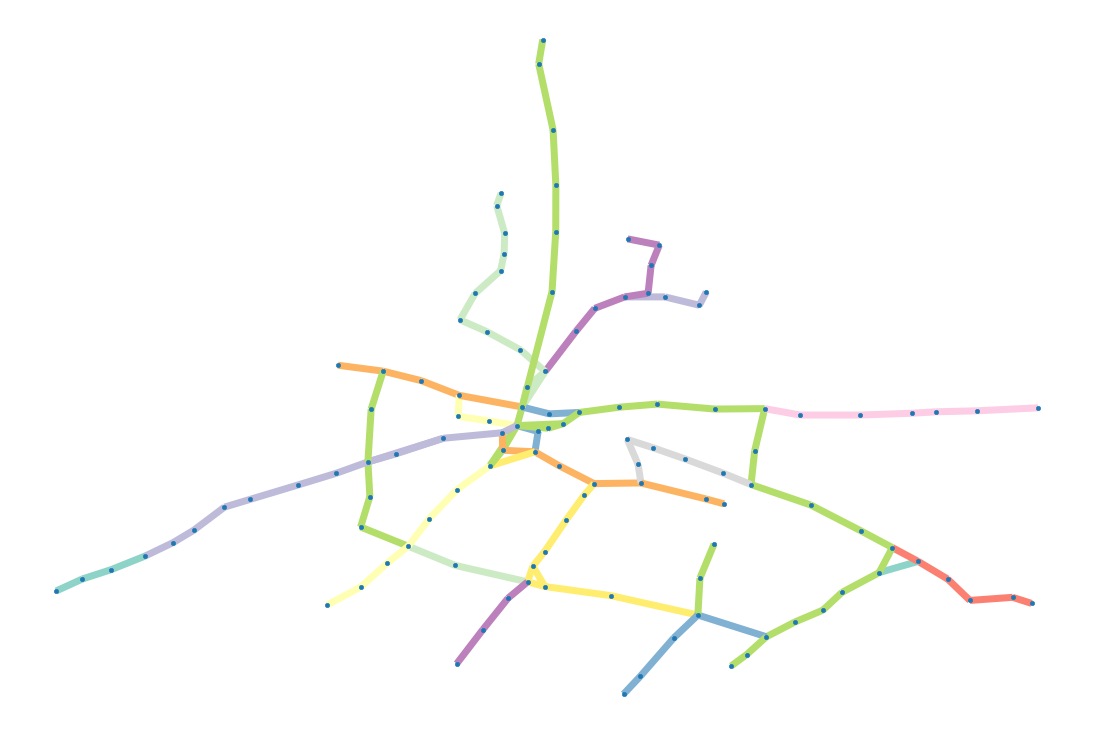

In [127]:
plt.figure(figsize=(15, 10))
colors = nx.get_edge_attributes(D, 'color').values()
nx.draw(D, nx.get_node_attributes(D, 'location'), with_labels=False, node_size=20, edge_color=colors, width=7)

In [128]:
shortest_paths = []

for source, target in tqdm(combinations(D.nodes(), 2)):
    path = nx.shortest_path(D, source=source, target=target)
    shortest_paths.append(Path(len(path), source, target))

7140it [00:00, 39527.44it/s]


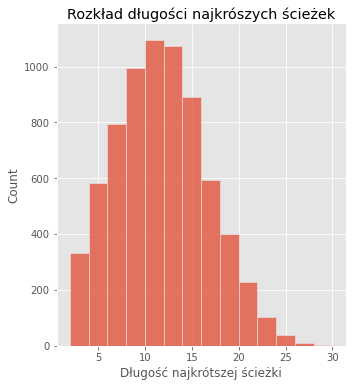

In [129]:
sns.displot(list(map(attrgetter('len'), shortest_paths)), binwidth=2)
plt.title("Rozkład długości najkrószych ścieżek")
plt.xlabel("Liczba ścieżek")
plt.xlabel("Długość najkrótszej ścieżki")
plt.show()

### Jakie to pary?

In [130]:
Path.__repr__ = lambda self: f'Len: {self.len:<3} {self.src:<15}{self.trg}'
nlargest(10, shortest_paths, attrgetter('len'))

[Len: 29  Junikowo       Franowo,
 Len: 28  Junikowo       Szwajcarska,
 Len: 28  Franowo        Cmentarna,
 Len: 27  Junikowo       Szwedzka,
 Len: 27  Franowo        Grotkowska,
 Len: 27  Franowo        Piątkowska,
 Len: 27  Szwajcarska    Cmentarna,
 Len: 26  Junikowo       Piaśnicka/Kurlandzka,
 Len: 26  Junikowo       Miłostowo,
 Len: 26  Franowo        Budziszyńska]

Obserwujemy, że rozkład ma taki sam kształt, a najdłuższe pary zawierają przystanki końcowe.
### Rozkład pośrednictwa

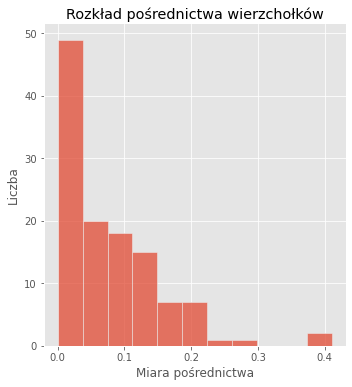

In [131]:
degree_sequence = nx.betweenness_centrality(D)

sns.displot(list(degree_sequence.values()))
plt.title("Rozkład pośrednictwa wierzchołków")
plt.ylabel("Liczba")
plt.xlabel("Miara pośrednictwa")
plt.show()

Z rozkładu wynika, że mamy kilka kluczowych przystanków, przez które przechodzi większość najkrótszych ścieżek:

In [133]:
for stop_name, centrality in nlargest(10, degree_sequence.items(), itemgetter(1)):
    print(f'{centrality:<5.2f}{stop_name}')

0.41 Most Teatralny
0.39 Rondo Kaponiera
0.28 Wielkopolska
0.26 Głogowska/Hetmańska
0.22 Traugutta
0.21 Kolejowa
0.20 Dworzec Zachodni
0.20 Rondo Śródka
0.20 Rondo Nowaka-Jeziorańskiego
0.20 Pl. Ratajskiego


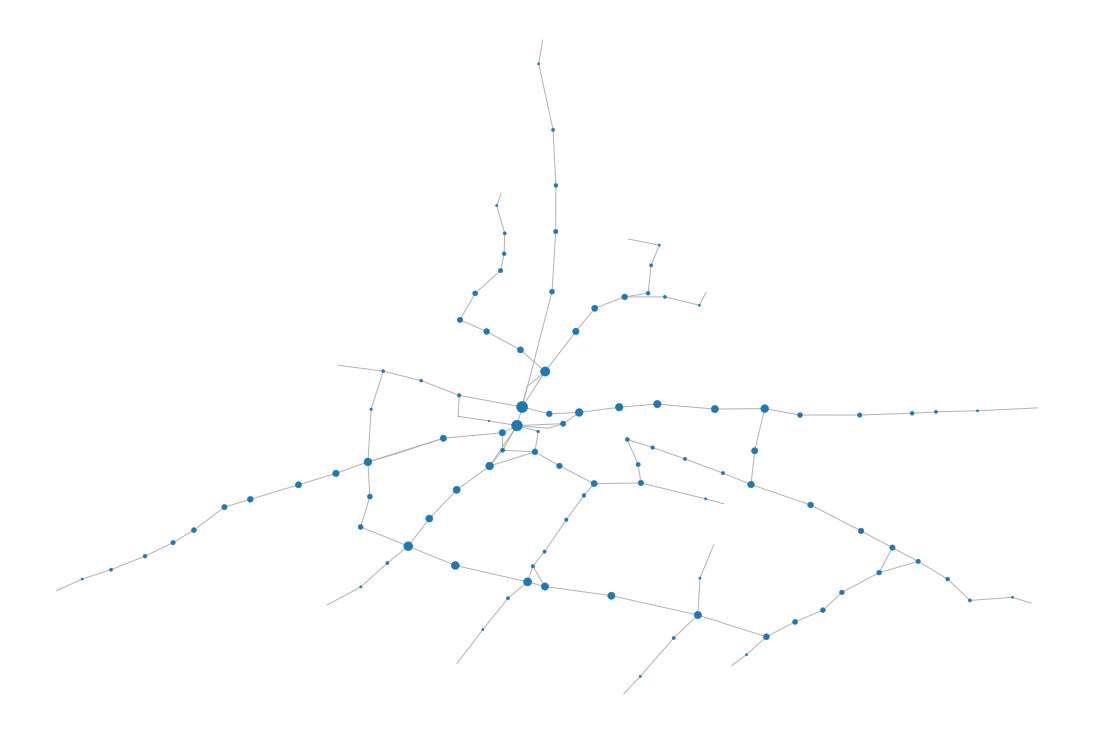

In [134]:
plt.figure(figsize=(15, 10))
colors = sns.color_palette('hls', n_colors=100)
node_size = np.array(list(degree_sequence.values())) * 300
nx.draw(D, nx.get_node_attributes(D, 'location'), with_labels=False, node_size=node_size, width=1,
        edge_color=[0.7, 0.7, 0.7])

Obserwujemy, że zgodnie z naszymi przewidywaniami najwyższą miarą pośrednictwa odznaczają się przystanki w centrum. Co ciekawe w naszym zestawieniu nie ma Mostu Dworcowego. Nasza miara nie uwzględnia tego jak dane linie przechodzą przez przystanki. Możemy to interpetować w ten sposób: w przypadku awarii na Moscie Dworcowym największa ilość tramwajów będzie musiała zmienić swoją trasę, natomiast w przypadku awarii na Moście Teatralnym lub Rondzie Kaponiera zmieni się największa ilość najkrótszych tras dla pasażerów. Na podstawie tych danych ciężko wywnioskować, która awaria stworzy więcej problemów w komunikacji - natomiast z całą pewnością możemy stwierdzić, że każda z nich będzie wyjątkowo odczuwalna.

### Rozkład lokalnych współczynników grupowania

In [135]:
clustering_coeff = nx.clustering(D)
for stop_name, coeff in nlargest(10, clustering_coeff.items(), itemgetter(1)):
    print(f'{coeff:<5.2f}{stop_name}')

1.00 Poznańska
1.00 Wojskowa
1.00 Zamek
0.50 Most Dworcowy
0.33 Piaśnicka Rynek
0.33 Os. Czecha
0.33 Rolna
0.33 Pamiątkowa
0.33 Os. Lecha
0.33 Dworzec Zachodni


Teoretycznie, bazując na tej metryce potrafilibyśmy znaleźć przystanki, na których awarie są najmniej bolesne i najłatwiej ja 'ominąć'. Jednak nie jest to do końca prawda i wynika to z tego jak budowany jest graf. Weźmy przykładowo przystanek Wojskowa. Miara 1 oznacza, że wszyscy sąsiedzi przystanku Wojskowa są połączeni linią i w przypadku awarii, możemy go ominąć. Nie jest to prawda, na trasie mamy kolejno Matejki - Wojskowa - Rondo Nowaka-Jeziorańskiego. Więc dlaczego z pomiarów wyszło nam połączenie między Matejki a Rondem JNJ? Ponieważ przystanek 'Wojskowa' jest tylko po jednej stronie i przykładowo linia 6 na Trasie Junikowo-Miłostwo zwyczajnie się tam nie zatrzymuje i tworzy krawędź w grafie, która w rzeczywistości nie istnieje.
### Gęstość

In [136]:
edges = len(D.edges())
vertices = len(D.nodes())
f'Gęstość: {edges / (vertices * (vertices - 1)):.3f}'

'Gęstość: 0.010'

Gęstość sieci jest mała, ponieważ zdecydowana większość wierzchołków ma 2-4 sąsiadów.
### Średnica

In [137]:
diameter = max(shortest_paths, key=attrgetter('len'))
diameter


Len: 29  Junikowo       Franowo

### Współczynnik centralności

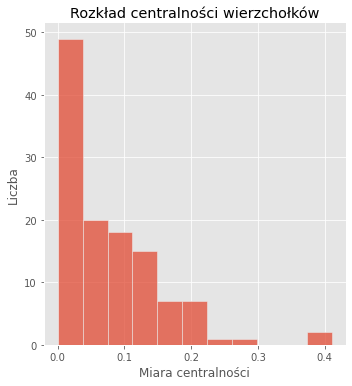

In [138]:
centrality = nx.eigenvector_centrality(D)

sns.displot(list(degree_sequence.values()))
plt.title("Rozkład centralności wierzchołków")
plt.ylabel("Liczba")
plt.xlabel("Miara centralności")
plt.show()

In [139]:
for stop_name, coeff in nlargest(10, centrality.items(), itemgetter(1)):
    print(f'{coeff:<5.2f}{stop_name}')

0.51 Rondo Kaponiera
0.44 Dworzec Zachodni
0.38 Most Dworcowy
0.28 Poznań Główny
0.25 Bałtyk
0.23 Most Teatralny
0.20 Towarowa
0.20 Gwarna
0.18 Zamek
0.15 Stare Zoo


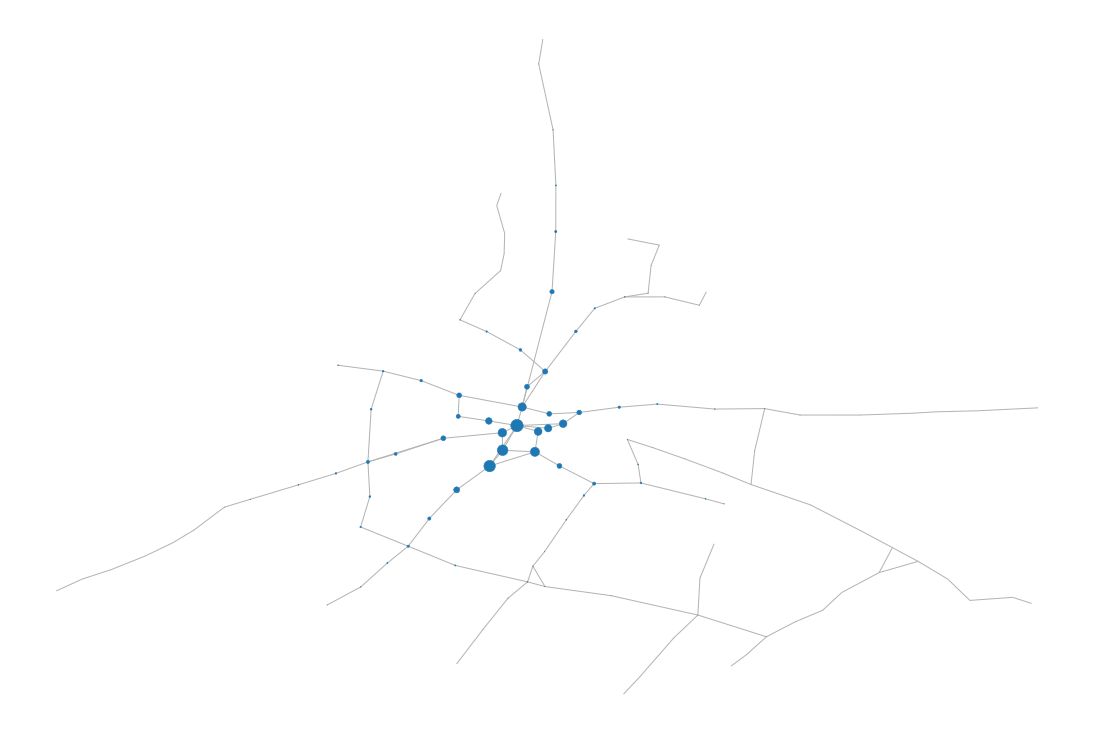

In [140]:
plt.figure(figsize=(15, 10))
colors = sns.color_palette('hls', n_colors=100)
node_size = np.array(list((centrality.values()))) * 300
nx.draw(D, nx.get_node_attributes(D, 'location'), with_labels=False, node_size=node_size, width=1,
        edge_color=[0.7, 0.7, 0.7])


Miara centralności alternatywnie pokazała inne przystanki, które są kluczowe. Warto zwrócić uwagę na przystaneki Rondo Jana Nowaka Jeziorańskiego oraz Słowiańska, które relatywnie, względem innych przystanków w okolicy również są ważne.
### Podział sieci na moduły

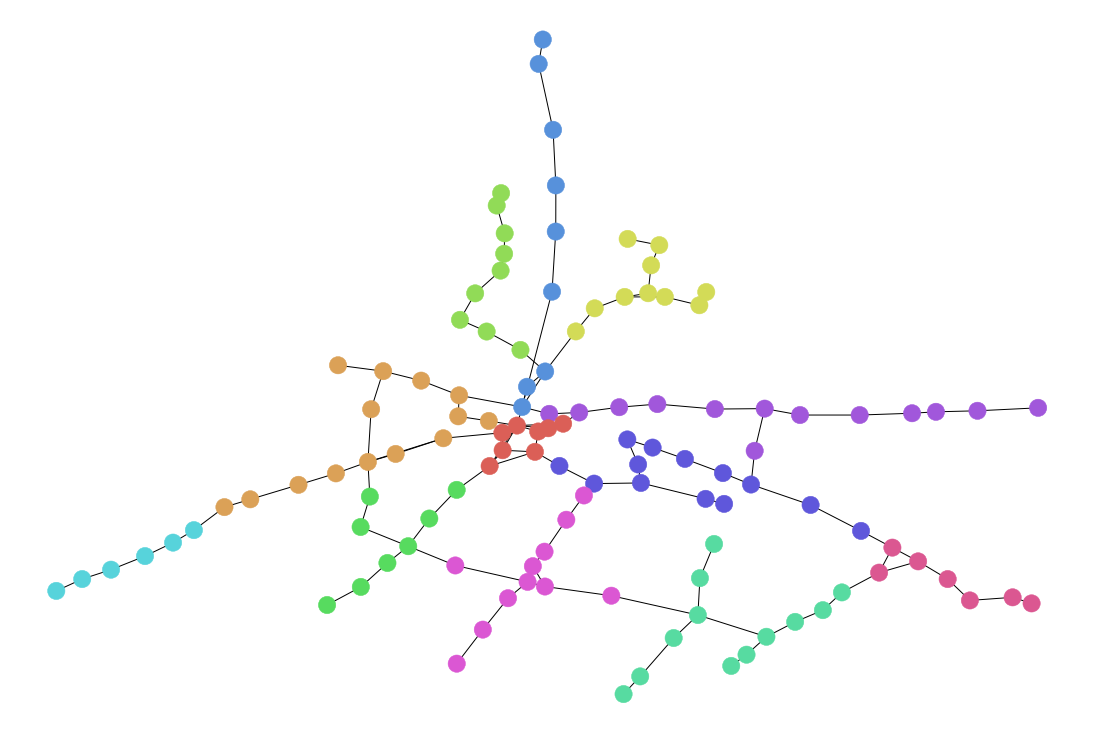

In [141]:
groups = greedy_modularity_communities(D)
colors = sns.color_palette('hls', n_colors=len(groups))
shuffle(colors)

node2color = {node_name: colors[group_id] for group_id, stops in enumerate(groups) for node_name in stops}
node_colors = [node2color[node] for node in D.nodes()]

plt.figure(figsize=(15, 10))
nx.draw(D, nx.get_node_attributes(D, 'location'), with_labels=False, node_size=300, node_color=node_colors)

Grupy można interpretować jak lokalizację między którymi, można łatwo się i szybko się przemieszczać.
### Poszukiwanie nowego połączenia
Poszukamy połączenia, które najbardziej zmniejszy średnią centralność, bądź średnią centralność kilku najbardziej centralnych przystanków.

In [150]:
def distance(origin, destination):
    origin = [radians(i) for i in origin[::-1]]
    destination = [radians(i) for i in destination[::-1]]
    d = 6371 * haversine_distances([origin], [destination])
    return d[0,0]


def find_new_edge(centrality_function, aggregate_centrality, loss):
    """
    :param centrality_function: nx.eigenvector_centrality or nx.betweenness_centrality
    :param aggregate_centrality: list or lambda x: nlargest(5, x)
    :param loss: function that takes as input mean_centrality and length of edge and return aggregated score
    """
    best_loss = float('inf')
    new_edge, new_centrality, new_G = [None] * 3
    for source, target in tqdm(combinations(D.nodes().keys(), 2)):
        if (source, target) in D.edges():
            continue

        T = deepcopy(D)
        T.add_edge(source, target, color=[1, 0, 0])

        centrality = centrality_function(T)
        mean_centrality = np.mean(aggregate_centrality(centrality.values()))
        d = distance(D.nodes()[source]['location'], D.nodes()[target]['location'])

        new_loss = loss(mean_centrality, d)

        if new_loss < best_loss:
            best_loss = new_loss
            new_edge, new_centrality, new_G = (source, target), centrality, deepcopy(T)

    print(f'New edge: {new_edge}')
    plt.figure(figsize=(15, 10))
    colors = nx.get_edge_attributes(new_G, 'color').values()
    node_size = np.array(list(new_centrality.values())) * 300
    nx.draw(new_G, nx.get_node_attributes(new_G, 'location'), with_labels=False, node_size=node_size, edge_color=colors,
            width=3)


7140it [01:16, 92.97it/s] 


New edge: ('Rondo Kaponiera', 'Poznań Główny')


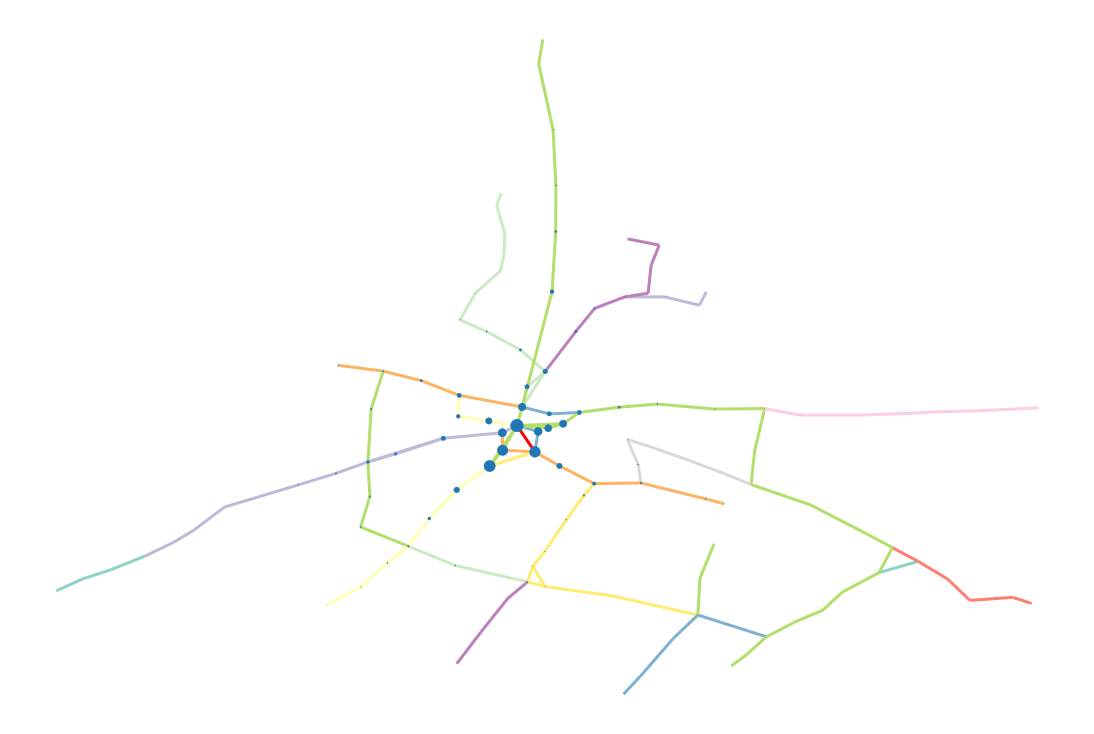

In [143]:
find_new_edge(
    centrality_function=nx.eigenvector_centrality,
    aggregate_centrality=list,
    loss=lambda cent, dis: cent
)


7140it [01:13, 97.13it/s] 


New edge: ('Rondo Kaponiera', 'Pl. Ratajskiego')


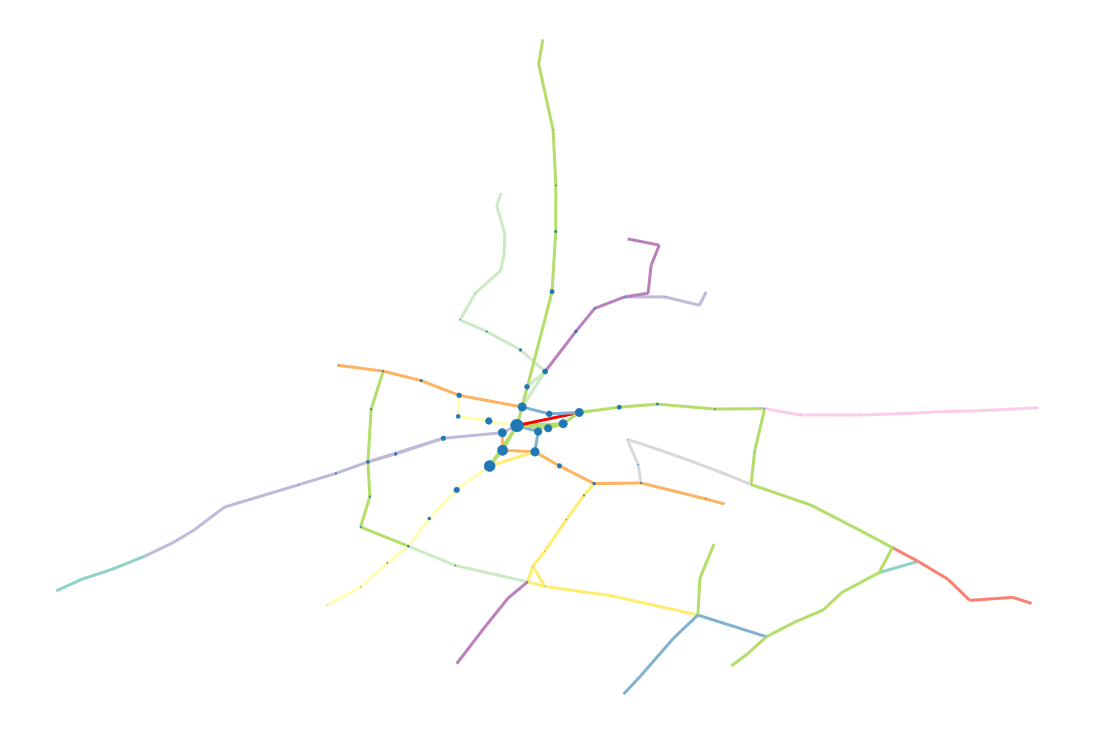

In [144]:
find_new_edge(
    centrality_function=nx.eigenvector_centrality,
    aggregate_centrality=lambda x: nlargest(5, x),
    loss=lambda cent, dis: cent
)


Wyniki wskazują, że należałoby utworzyć połączenie od Ronda Kaponiera do innego niezbyt odległego przystanku. Taka krawędź pozwaliłaby na lepsze 'rozłożenie' się mierze centralności pomiędzy wierzchołkami. Natomiast w naszym przypadku nie do końca jest to dobra odpowiedź. W dalszym ciągu awaria przystanku Rondo Kaponiera paraliżuje ruch. Spróbujemy więc zminimalizować miarę pośrednictwa.

7140it [04:44, 25.13it/s]


New edge: ('Rondo Żegrze', 'Most Teatralny')


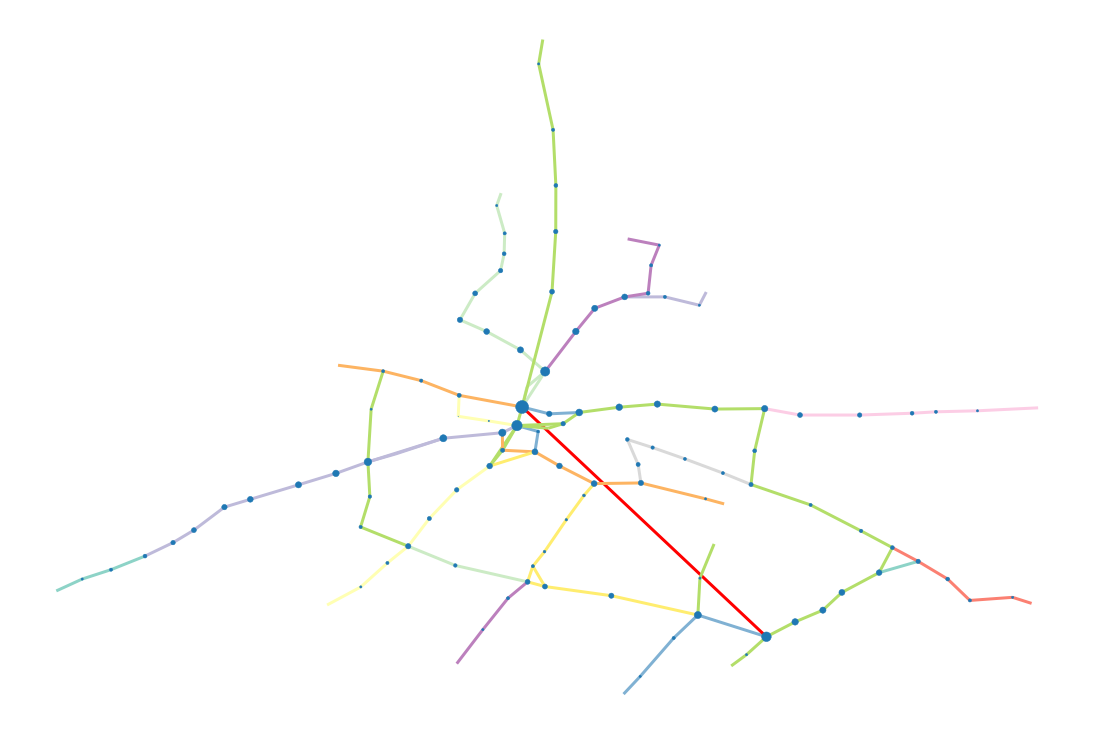

In [145]:
find_new_edge(
    centrality_function=nx.betweenness_centrality,
    aggregate_centrality=list,
    loss=lambda cent, dis: cent
)


7140it [05:33, 21.41it/s]


New edge: ('Wierzbięcice', 'Armii Poznań')


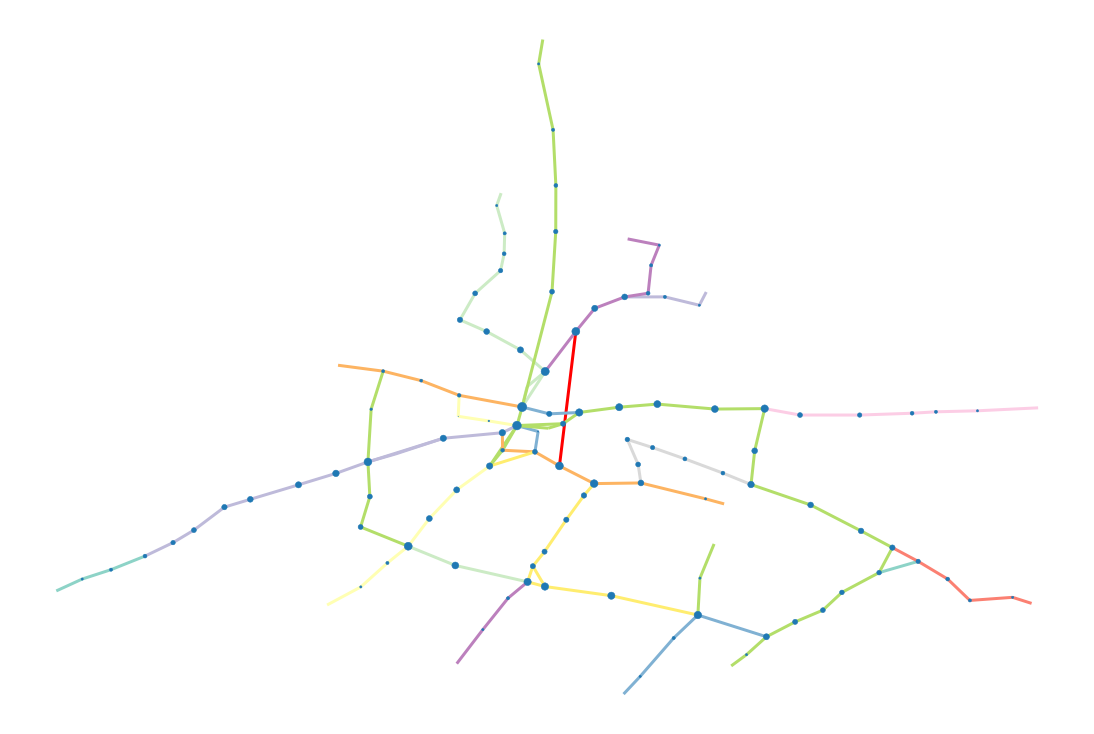

In [146]:
find_new_edge(
    centrality_function=nx.betweenness_centrality,
    aggregate_centrality=lambda x: nlargest(5, x),
    loss=lambda cent, dis: cent
)

Wyniki, które uzyskaliśmy z pewnością zmniejszają pośrednictwo, natomiast otrzymane trasy przecinają się z innymi trasami i ich rozmieszczenie jest zwyczajnie bez sensu. Spróbujemy optymalizować dwa parametry: jednym z nich będzie pośrednictwo a drugim dystans. Oba znormalizujemy tak aby najgorszy przypadek miał wartość 1 oraz dodamy wagę do odległości, tak aby można było sterować jej wpływem na wynik.


In [151]:
max_between_centrality = max(nx.betweenness_centrality(D).values())
max_distance = float('-inf')
for source, target in tqdm(combinations(D.nodes().keys(), 2)):
    d = distance(D.nodes()[source]['location'], D.nodes()[target]['location'])
    if d > max_distance:
        max_distance = d
max_distance, max_between_centrality

7140it [00:00, 38273.31it/s]


(11.774164665469572, 0.41088164079191)

7140it [04:59, 23.81it/s]


New edge: ('Poznań Główny', 'Klin')


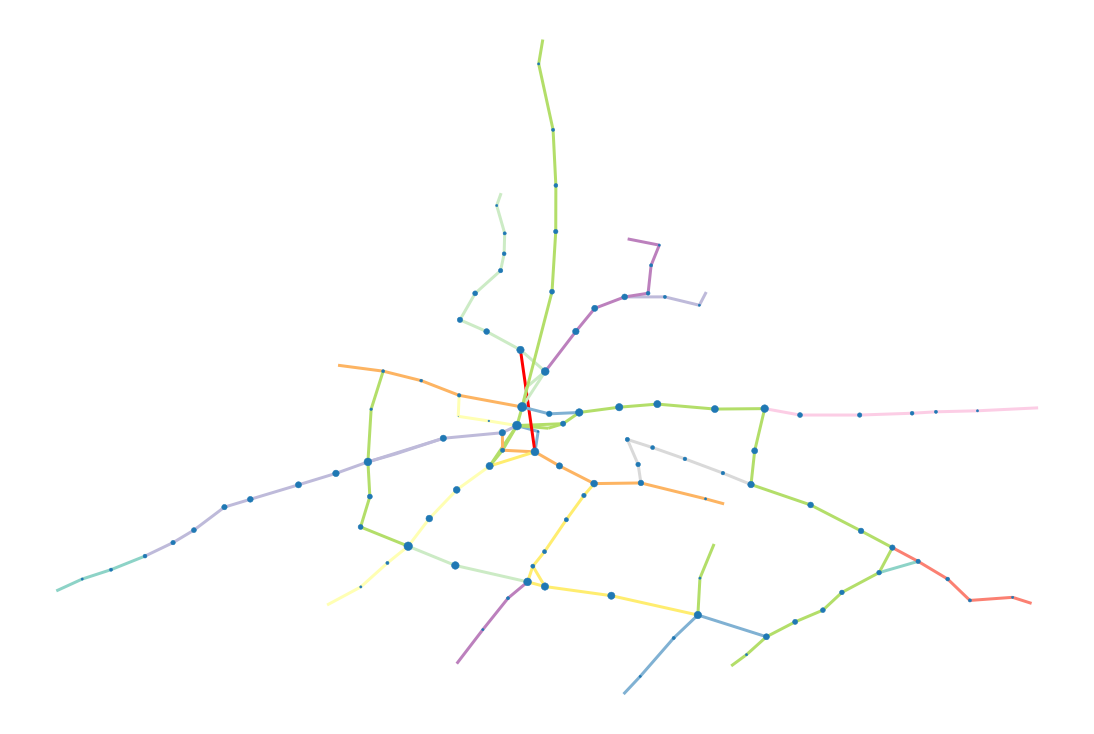

In [152]:
find_new_edge(
    centrality_function=nx.betweenness_centrality,
    aggregate_centrality=lambda x: nlargest(5, x),
    loss=lambda cent, dis: cent/max_between_centrality + 0.5 * dis/max_distance
)

In [ ]:
find_new_edge(
    centrality_function=nx.betweenness_centrality,
    aggregate_centrality=lambda x: nlargest(5, x),
    loss=lambda cent, dis: cent/max_between_centrality + 1 * dis/max_distance
)

4951it [03:24, 26.10it/s]

In [ ]:
find_new_edge(
    centrality_function=nx.betweenness_centrality,
    aggregate_centrality=lambda x: nlargest(5, x),
    loss=lambda cent, dis: cent/max_between_centrality + 2 * dis/max_distance
)

In [ ]:
find_new_edge(
    centrality_function=nx.betweenness_centrality,
    aggregate_centrality=list,
    loss=lambda cent, dis: cent/max_between_centrality + 0.5 * dis/max_distance
)

In [ ]:
find_new_edge(
    centrality_function=nx.betweenness_centrality,
    aggregate_centrality=list,
    loss=lambda cent, dis: cent/max_between_centrality + 1 * dis/max_distance
)

In [ ]:
find_new_edge(
    centrality_function=nx.betweenness_centrality,
    aggregate_centrality=list,
    loss=lambda cent, dis: cent/max_between_centrality + 2 * dis/max_distance
)

# Podsumowanie
Na podstawie naszej analizy dowiedzieliśmy się, że kluczowe dla Poznania przystanki tramwajowe to Rondo Kaponiera oraz Most Dworcowy. Dalsze testy wskazały, że przy naszych uproszczonnych założenia najlepszą trasą do dodania będzie:
